# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business requirement here is to leverage used car sales data to better understand purchasing decisions of customers. We should examine all dimensions in the data to see which features have an impact in determining how much a customer will pay for a car.

We can use correlation and linear models to measure feature importance. Linear regression coefficients will suggest the magnitude of the relationship, and once we have this we can then inform the business on which levers they can manipulate to sell more cars or sell cars at a higher price. I will use a number of techniques in linear modeling to find the most accurate models (Sequential Feature Selection, Polynomial Features, Grid Search), and will apply regularization (L1, L2) if we want to limit the magnitude of coefficients.

If there are no obvious relationships in the data, we can try K-means clustering to try and identify similar pricing dynamics among certain groups of cars. If we have a large number of dimensions in the raw data, we can use PCA to reduce dimensionality while maintaining most of the variation in the data set.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Examine all column and column types. Check how many missing values are in the data set.
2. How many unique values in each column? Are there ordinal string columns?
3. Are there levels to the data? Geographic, time, etc.
4. Chart data to view general trends and relationships (pairplot)
5. Make correlation matrix to see related fields

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('data/vehicles.csv')

In [3]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

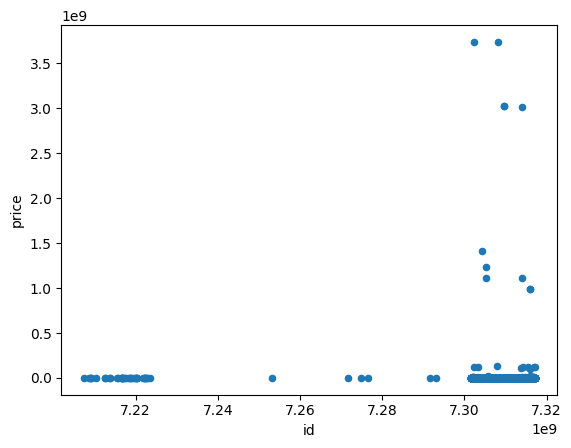

In [5]:
# drop id and VIN since these have no impact on price
df.plot(kind='scatter', x='id', y='price')
df = df.drop(columns=['id','VIN'])

<Axes: ylabel='Frequency'>

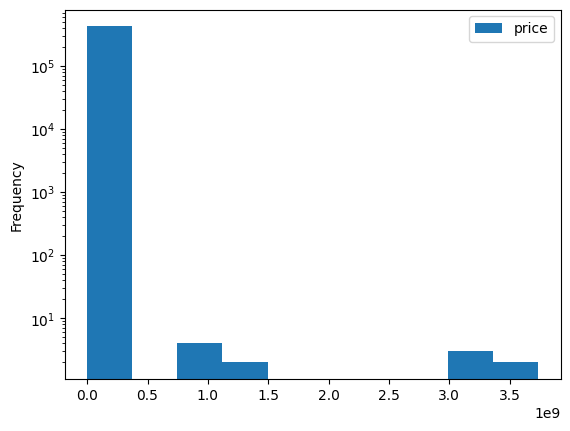

In [6]:
# Inspect distribution of price. Any outliers or strange trends?
# Use log scale to see the outliers around 3 and 1 e^9
df[['price']].plot(kind='hist', logy=True)

In [7]:
# There are outliers with prices of over $1b. Limiting to below $100k is reasonable
# given anything above that in this data set is extremely rare. Our model will not be good
# at predicting in that price region so I'd just limit training data to 100k.
df.query('price < 100000').sort_values('price', ascending=False).head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
77605,denver,99999,2015.0,jeep,wrangler unlimited rubicon,NaN,8 cylinders,gas,15944.0,clean,automatic,4wd,NaN,SUV,NaN,co
255553,north jersey,99999,2021.0,chevrolet,corvette,new,8 cylinders,gas,1.0,clean,automatic,rwd,NaN,NaN,black,nj
44134,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
44389,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
246133,scottsbluff / panhandle,99999,2020.0,ford,f-150 shelby edition,excellent,8 cylinders,gas,9600.0,clean,automatic,4wd,NaN,pickup,blue,ne


In [8]:
# almost 33k rows where price = 0, a minimum price of $1000 will probably drop a lot of incorrect data and is a reasonable minimum price of a pricing model
df.query('price < 1000').head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
10,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx


<Axes: ylabel='Frequency'>

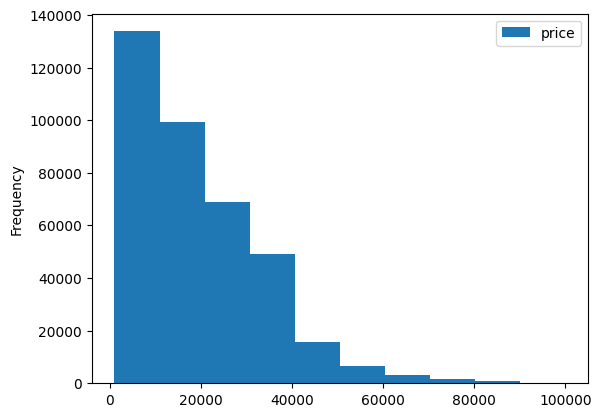

In [9]:
# This looks like a more reasonable price distribution. I think anything above
# $100k is more of a special sale and not something that needs to be modeled.
df[['price']].query('price < 100000 and price > 1000').plot(kind='hist')

In [10]:
# Limit data to between $1k and $100k
df = df.query('price >= 1000 and price <= 100000')

In [11]:
# Column % missing values
# Quite a few columns are over 20% null. For the others maybe we can drop rows
(df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).round(1)

size            71.8
cylinders       40.8
condition       37.7
drive           30.3
paint_color     28.6
type            21.3
manufacturer     3.9
title_status     1.7
model            1.2
fuel             0.7
odometer         0.5
transmission     0.5
year             0.3
region           0.0
price            0.0
state            0.0
dtype: float64

In [12]:
# size is 72% missing, and the categories don't look informative anyway
# drop this column
df.groupby('size', dropna=False)['price'].mean()
df = df.drop(columns='size')

In [13]:
# cylinders is 41% missing. I checked a couple correlations and did
# not see anything we could use to impute missing values. Filling in
# a mean or some stat would create too much bias given it's 41% of the data.
df.value_counts('cylinders', dropna=False)
df = df.drop(columns='cylinders')

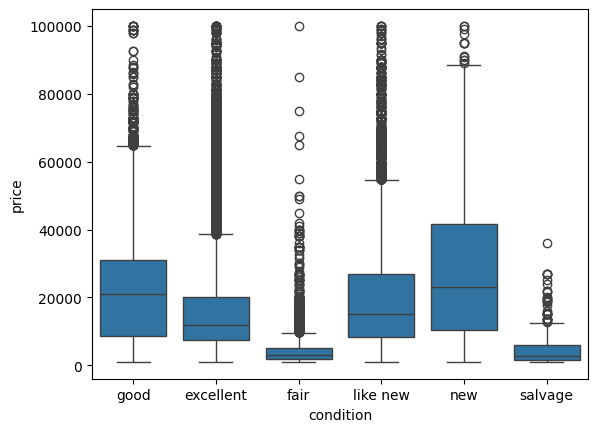

In [23]:
# The condition does not look like it has a strong effect on price. They are
# ordinal (from salvage to new) but the pricing is not linear. New, like new, good,
# and excellent are all very close in mean price. 

# Given this is 41% missing, I will drop this column
sns.boxplot(df, x='condition',y='price')
df = df.drop(columns='condition')

drive
4wd    115942
NaN    115013
fwd     94794
rwd     54161
Name: count, dtype: int64

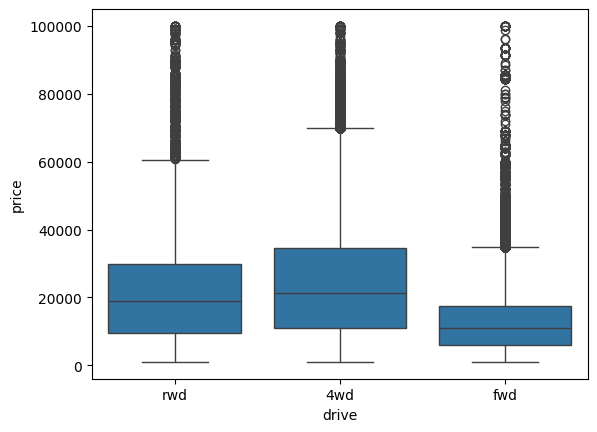

In [49]:
# drive is also largely 30% without a big trend on price. Dropping
display(df.value_counts('drive', dropna=False))
sns.boxplot(df, x='drive', y='price')
df = df.drop(columns='drive')

paint_color
NaN       108588
white      71528
black      57489
silver     39300
blue       28866
red        28332
grey       22269
green       6848
custom      6164
brown       6066
yellow      1991
orange      1815
purple       654
Name: count, dtype: int64

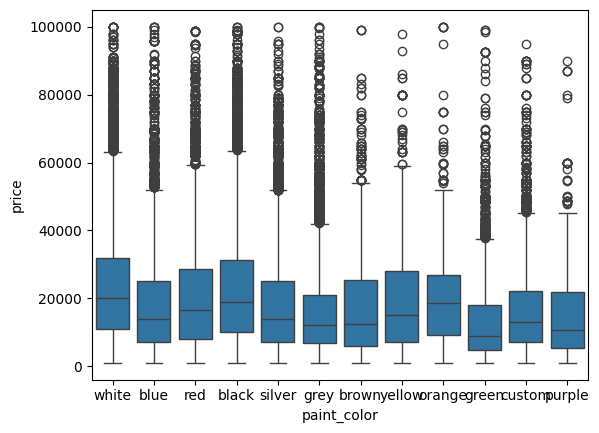

In [53]:
# paint_color is mostly missing and has a lot of values with small frequency
# like purple, organge, yellow. I don't think it's worth adding variation to the model
# predict prices of such rare colors.

# The prices are all similar each with many outliers. Dropping
display(df.value_counts('paint_color', dropna=False))
sns.boxplot(df, x='paint_color', y='price')
df = df.drop(columns='paint_color')

In [54]:
df.value_counts('type', dropna=False)

type
NaN            81073
sedan          77409
SUV            67991
pickup         41058
truck          29460
other          19527
coupe          17557
hatchback      15556
wagon           9748
van             7804
convertible     7223
mini-van        4460
offroad          582
bus              462
Name: count, dtype: int64

In [80]:
# Long dataframe of value counts per column
melted = (pd.melt(df, var_name='column', value_name='value').
          value_counts(dropna=False).reset_index().sort_values(['column','count'], ascending=False))

In [73]:
# # of unique values per column
melted.value_counts('column').reset_index()

,column,count
0,odometer,96517
1,model,27090
2,price,14615
3,region,404
4,year,112
5,state,51
6,manufacturer,43
7,type,14
8,paint_color,13
9,cylinders,9


In [ ]:
# 

In [57]:
# Inspect columns with high % of missing values. Drop rows, drop columns, or impute values?
df['size'].value_counts(dropna=False)

size
NaN            306361
full-size       63465
mid-size        34476
compact         19384
sub-compact      3194
Name: count, dtype: int64

In [65]:
# Rows with missing size values also have missing VIN, condition, and cylinder information.
# Since these rows still have a lot of other information, I will just drop this column.
(df.loc[df['size'].isna() == False].isna().sum())/df.shape[0]*100

id               0.000000
region           0.000000
price            0.000000
year             0.000000
manufacturer     1.222358
model            0.427521
condition        5.532468
cylinders        2.894490
fuel             0.001406
odometer         0.184361
title_status     0.050600
transmission     0.053645
VIN             15.944996
drive            2.316108
size             0.000000
type             0.926958
paint_color      1.562500
state            0.000000
dtype: float64

<Axes: xlabel='size', ylabel='price'>

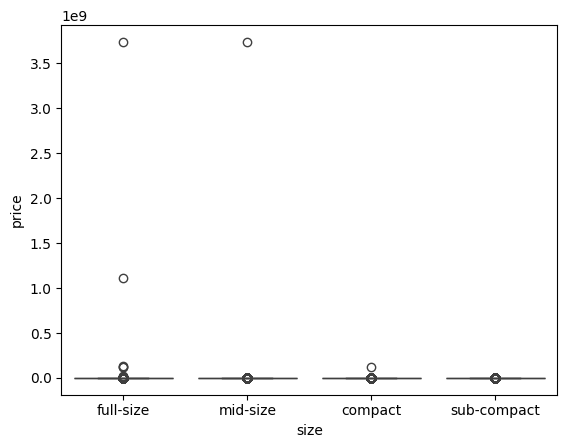

In [71]:
sns.boxplot(df, x='size', y='price')

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Based on the above findings, we should:
1. Drop identification columns as they have no impact on the cars themselves (id, VIN)
2. Drop columns that are over X% null.
3. Impute values to fill in missing data

In [ ]:
# Drop VIN and ID

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

1. Try dropping columns with null values
2. Try models that keep these columns, but drop null rows

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.